# Exercício 03

**Instruções gerais:** Sua submissão <u>deve</u> conter:
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

## Redução de dimensionalidade

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm

import time

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser achados em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [4]:
# Importando o dataset:
data = torch.from_numpy(pd.read_csv("/penguins.csv", header=None).to_numpy())

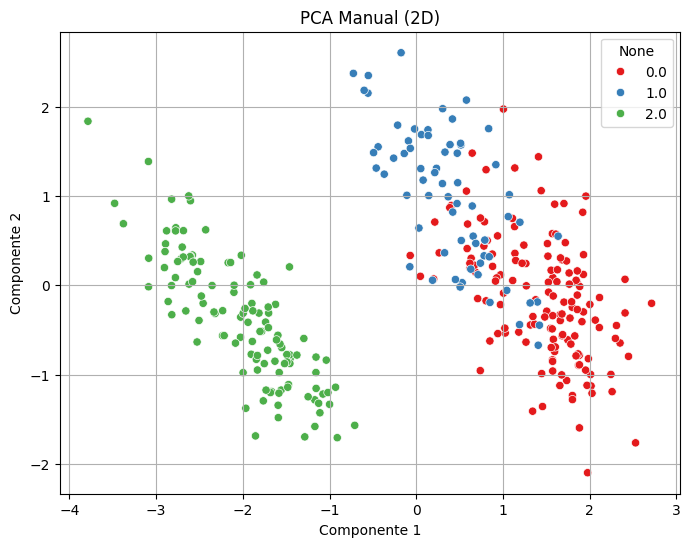

==== Variância explicada (implementação manual) ====
1 componentes: 0.6863
2 componentes: 0.8809
3 componentes: 0.9730
4 componentes: 1.0000

==== Variância explicada (scikit-learn) ====
Componente 1: 0.6863
Componente 2: 0.1945
Componente 3: 0.0922
Componente 4: 0.0270
Total acumulado: [0.68633894 0.88086822 0.97302885 1.        ]


In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as SKPCA
from sklearn.preprocessing import StandardScaler

# Atributos (4 colunas) e classe (última coluna)
X = data[:, :-1].float()
y = data[:, -1]

# === 2. Normalizar os dados ===
scaler = StandardScaler()
X_norm_np = scaler.fit_transform(X)
X_norm = torch.from_numpy(X_norm_np)

# === 3. Implementar PCA manualmente ===
def pca_torch(X, k):
    # Matriz de covariância
    cov_matrix = torch.mm(X.T, X) / (X.shape[0] - 1)
    eigvals, eigvecs = torch.linalg.eigh(cov_matrix)

    # Ordenar decrescentemente
    sorted_idx = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[sorted_idx]
    eigvecs = eigvecs[:, sorted_idx]

    # Projetar
    components = eigvecs[:, :k]
    X_reduced = torch.mm(X, components)

    return X_reduced, eigvals

# === 4. Aplicar PCA manual com 2 componentes ===
X_2d, eigvals = pca_torch(X_norm, 2)
X_2d_np = X_2d.numpy()

# === 5. Visualização 2D da projeção manual ===
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d_np[:,0], y=X_2d_np[:,1], hue=y, palette="Set1")
plt.title("PCA Manual (2D)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

# === 6. Comparar com PCA do scikit-learn ===
sk_pca = SKPCA(n_components=2)
X_2d_sklearn = sk_pca.fit_transform(X_norm_np)

# === 7. Variância explicada manual ===
def explained_variance(eigvals):
    total = eigvals.sum()
    return eigvals / total

var_exp = explained_variance(eigvals)

print("==== Variância explicada (implementação manual) ====")
for i in range(4):
    print(f"{i+1} componentes: {var_exp[:i+1].sum().item():.4f}")

# === 8. Variância explicada scikit-learn ===
sk_pca_full = SKPCA(n_components=4)
sk_pca_full.fit(X_norm_np)

print("\n==== Variância explicada (scikit-learn) ====")
for i, var in enumerate(sk_pca_full.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.4f}")
print("Total acumulado:", np.cumsum(sk_pca_full.explained_variance_ratio_))


**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [6]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:10<00:00, 906kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 59.4kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.50MB/s]


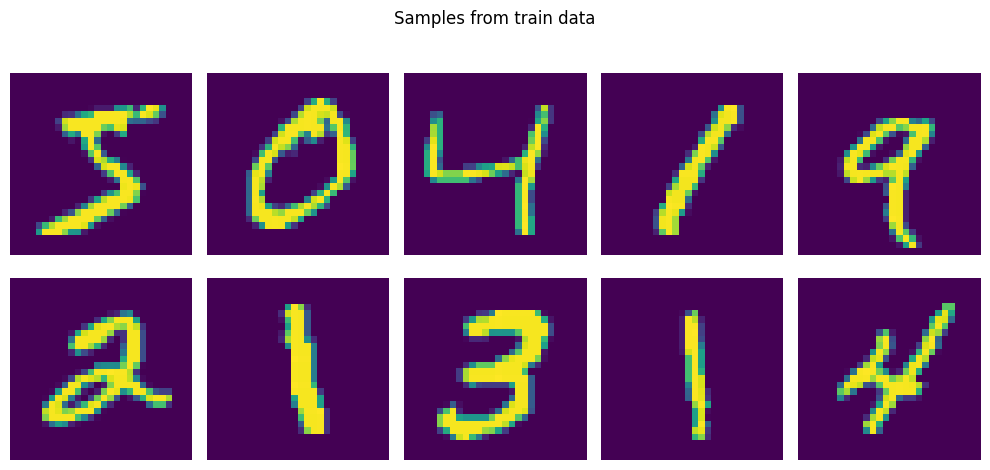

In [7]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')

fig.suptitle("Samples from train data")
fig.tight_layout()

# Usando CNN


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.0759, Val Loss: 0.0554
Epoch 2, Train Loss: 0.0513, Val Loss: 0.0487
Epoch 3, Train Loss: 0.0472, Val Loss: 0.0460
Epoch 4, Train Loss: 0.0451, Val Loss: 0.0445
Epoch 5, Train Loss: 0.0438, Val Loss: 0.0432
Epoch 6, Train Loss: 0.0428, Val Loss: 0.0426
Epoch 7, Train Loss: 0.0422, Val Loss: 0.0420
Epoch 8, Train Loss: 0.0417, Val Loss: 0.0418
Epoch 9, Train Loss: 0.0412, Val Loss: 0.0412
Epoch 10, Train Loss: 0.0409, Val Loss: 0.0409
Epoch 11, Train Loss: 0.0405, Val Loss: 0.0406
Epoch 12, Train Loss: 0.0403, Val Loss: 0.0406
Epoch 13, Train Loss: 0.0401, Val Loss: 0.0403
Epoch 14, Train Loss: 0.0398, Val Loss: 0.0401
Epoch 15, Train Loss: 0.0397, Val Loss: 0.0399
Epoch 16, Train Loss: 0.0395, Val Loss: 0.0400
Epoch 17, Train Loss: 0.0393, Val Loss: 0.0397
Epoch 18, Train Loss: 0.0392, Val Loss: 0.0395
Epoch 19, Train Loss: 0.0390, Val Loss: 0.0394
Epoch 20, Train Loss: 0.0389, Val Loss: 0.0394
Epoch 21, Train Loss: 0.0388, Val Loss: 0.0393
Epoch 22, Train Loss: 

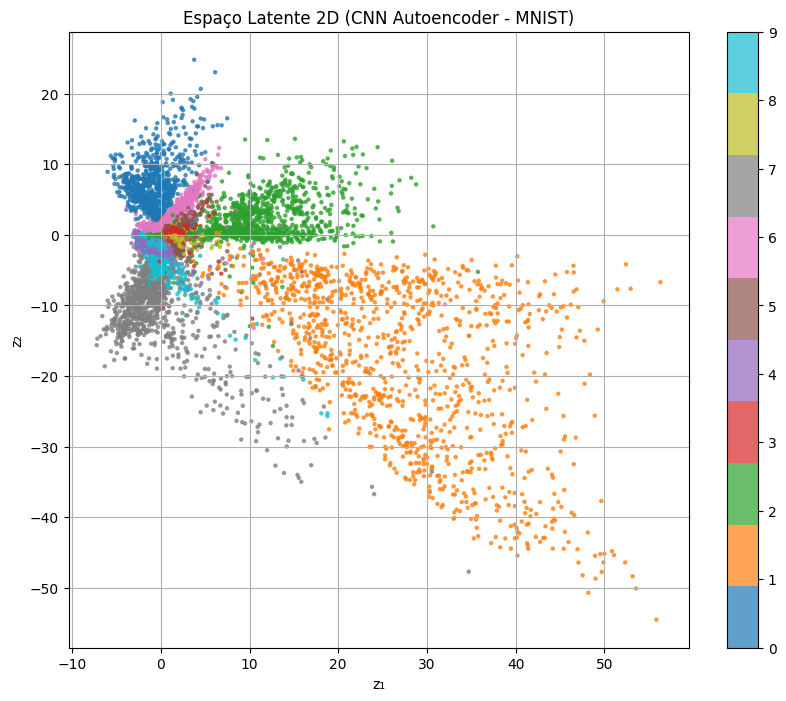

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Dataset e splits
transform = transforms.ToTensor()
train_val_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

# Autoencoder CNN
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Inicialização
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# Treinamento com early stopping
best_val_loss = float('inf')
patience = 10
counter = 0
for epoch in range(100):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_hat = model(x)
            val_loss += criterion(x_hat, x).item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_model)

# Projeção no espaço latente
model.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = model.encoder(x)
        latents.append(z.cpu().numpy())
        labels.append(y.numpy())
latents = np.concatenate(latents)
labels = np.concatenate(labels)

# Visualização
plt.figure(figsize=(10, 8))
sc = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
plt.colorbar(sc, ticks=range(10))
plt.title("Espaço Latente 2D (CNN Autoencoder - MNIST)")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()


# Usando MLP

Epoch 1, Train Loss: 0.0672, Val Loss: 0.0548
Epoch 2, Train Loss: 0.0521, Val Loss: 0.0506
Epoch 3, Train Loss: 0.0488, Val Loss: 0.0479
Epoch 4, Train Loss: 0.0465, Val Loss: 0.0462
Epoch 5, Train Loss: 0.0449, Val Loss: 0.0448
Epoch 6, Train Loss: 0.0437, Val Loss: 0.0439
Epoch 7, Train Loss: 0.0429, Val Loss: 0.0433
Epoch 8, Train Loss: 0.0423, Val Loss: 0.0428
Epoch 9, Train Loss: 0.0418, Val Loss: 0.0424
Epoch 10, Train Loss: 0.0413, Val Loss: 0.0421
Epoch 11, Train Loss: 0.0409, Val Loss: 0.0417
Epoch 12, Train Loss: 0.0406, Val Loss: 0.0414
Epoch 13, Train Loss: 0.0402, Val Loss: 0.0412
Epoch 14, Train Loss: 0.0399, Val Loss: 0.0409
Epoch 15, Train Loss: 0.0397, Val Loss: 0.0406
Epoch 16, Train Loss: 0.0395, Val Loss: 0.0406
Epoch 17, Train Loss: 0.0392, Val Loss: 0.0406
Epoch 18, Train Loss: 0.0390, Val Loss: 0.0403
Epoch 19, Train Loss: 0.0388, Val Loss: 0.0401
Epoch 20, Train Loss: 0.0387, Val Loss: 0.0399
Epoch 21, Train Loss: 0.0385, Val Loss: 0.0398
Epoch 22, Train Loss: 

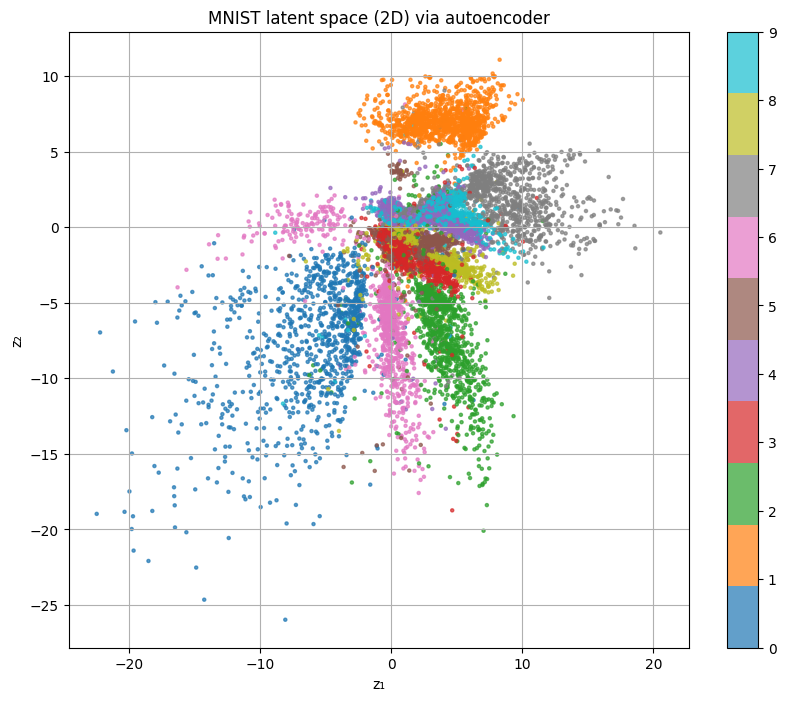

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

transform = transforms.ToTensor()

train_val_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # espaço latente 2D
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # saída normalizada
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x, _ = batch
        x = x.to(device)
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x, _ = batch
            x = x.to(device)
            x_hat = model(x)
            val_loss += criterion(x_hat, x).item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model)

model.eval()
latents = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = model.encoder(x)
        latents.append(z.cpu().numpy())
        labels.append(y.numpy())

latents = np.concatenate(latents)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("MNIST latent space (2D) via autoencoder")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()


## Observações sobre os resultados

### Primeira imagem: CNN Autoencoder
**Legenda:** *"Espaço Latente 2D (CNN Autoencoder - MNIST)"*

- Os clusters de diferentes dígitos estão mais bem separados.
- Os dígitos como **'1'**, **'2'** e **'3'** formam agrupamentos compactos e distinguíveis.
- A arquitetura convolucional extrai melhor as características espaciais das imagens, o que facilita a separação dos dígitos no espaço latente.
- Os dígitos com formatos visuais similares (ex: **4**, **9** e **7**) têm regiões com sobreposição, mas ainda mostram certa estrutura.

 **Ponto forte**: Excelente capacidade de separar as classes no espaço latente, o que mostra que a CNN consegue extrair boas representações hierárquicas das imagens.

---

### Segunda imagem: MLP Autoencoder (provável)
**Legenda:** *"MNIST latent space (2D) via autoencoder"*

- Os clusters são mais sobrepostos, especialmente nos dígitos **3**, **5**, **6** e **8**.
- Menor compactação dos grupos, com pontos espalhados e menos estrutura.
- Como a MLP não explora a topologia espacial da imagem (cada pixel é tratado separadamente), ela tende a formar representações menos discriminativas.
- Ainda assim, vemos alguns agrupamentos razoáveis (como o **'1'** no topo e o **'0'** à esquerda).

 **Limitação**: O modelo MLP pode sofrer com a alta dimensionalidade e falta de sensibilidade a padrões locais, resultando em embeddings menos organizados.

---

A comparação entre os dois tipos de autoencoder mostra claramente a **superioridade qualitativa do CNN autoencoder** em aprender representações latentes mais informativas e bem separadas.  
Isso acontece porque convoluções preservam a **estrutura espacial dos dados**, capturando bordas, formas e padrões locais — essenciais para distinguir os dígitos do MNIST.

---

- **CNN**: Melhor performance qualitativa na separação de classes no espaço latente. Ideal para tarefas que exigem embeddings estruturados.
- **MLP**: Pode funcionar, mas tem dificuldade em aprender representações discriminativas em espaços de baixa dimensionalidade como ℝ².

## K-means e Mixture models

## Exercícios práticos

In [10]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,
                                                           transform=torchvision.transforms.ToTensor())

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                            transform=torchvision.transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 163kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.10MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.3MB/s]


In [11]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
        if i >= 8: break
    plt.suptitle(dataset.__class__.__name__)
    plt.tight_layout()

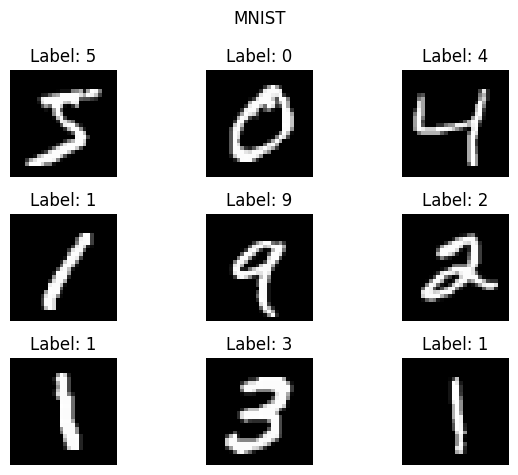

In [12]:
display_nine_images(mnist_trainset)

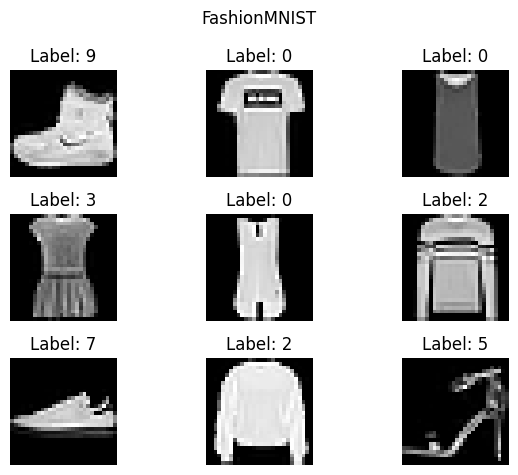

In [13]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

Acurácia do agrupamento (K-means com médias por classe): 0.5939


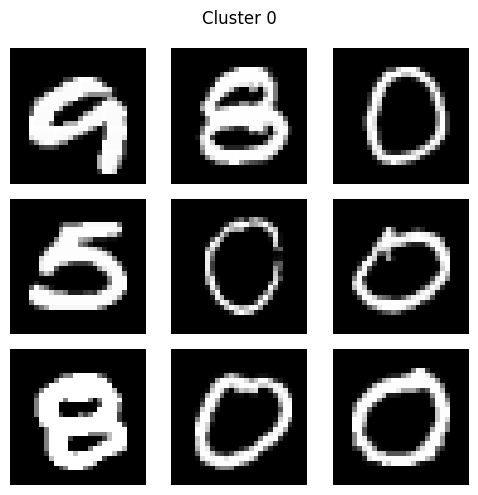

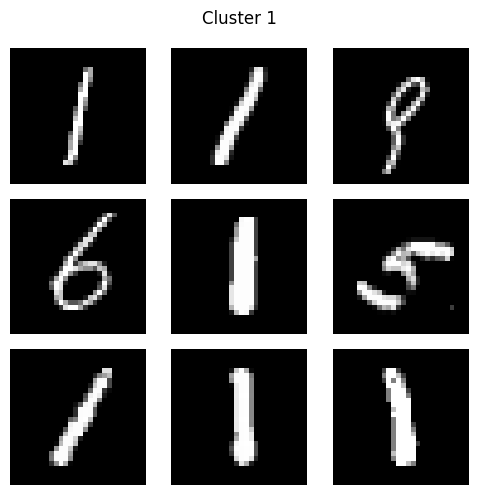

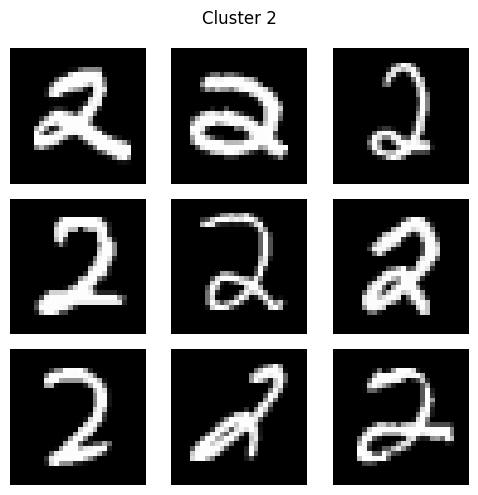

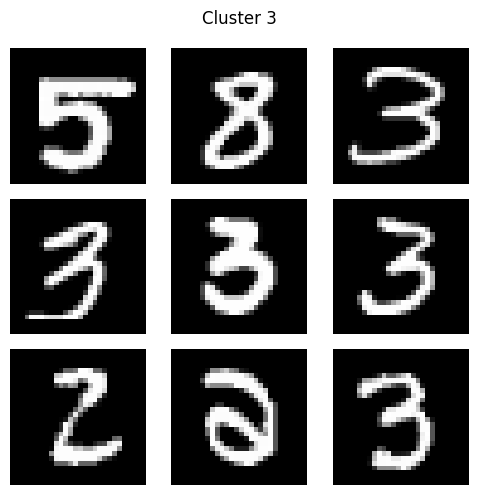

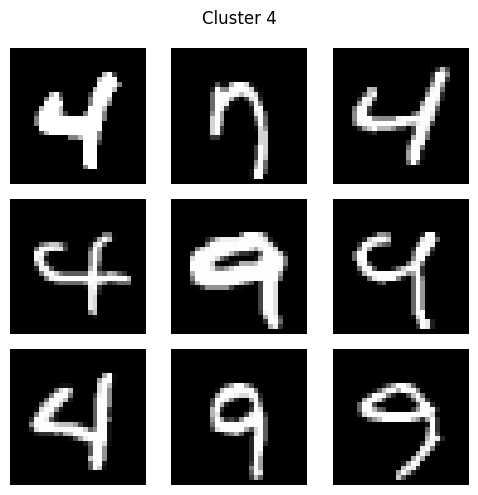

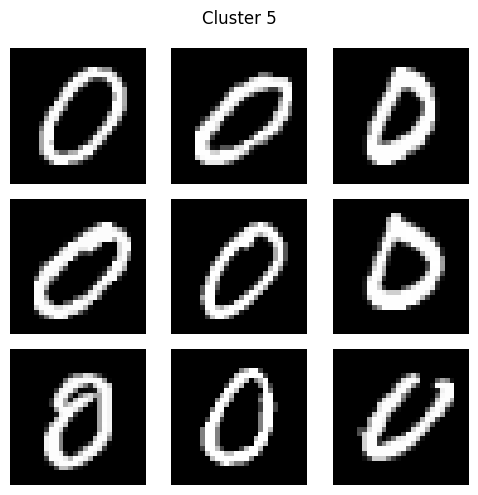

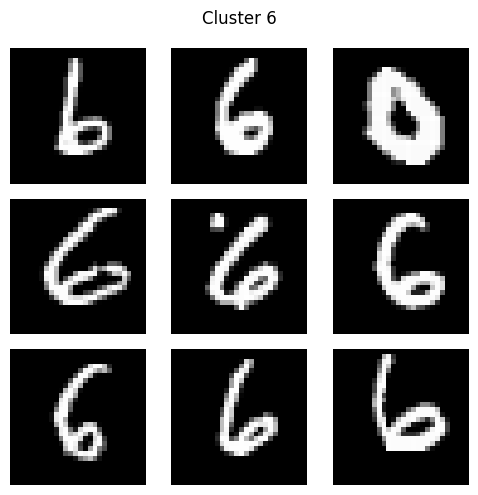

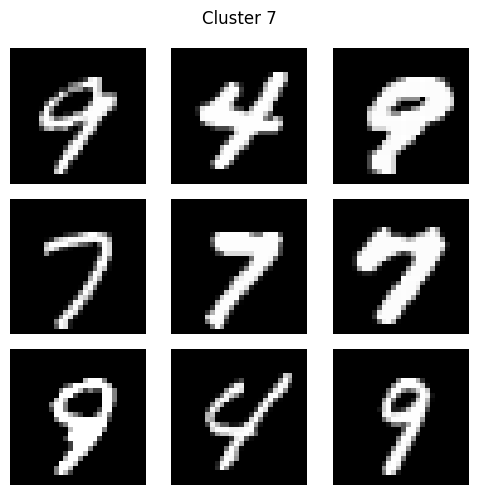

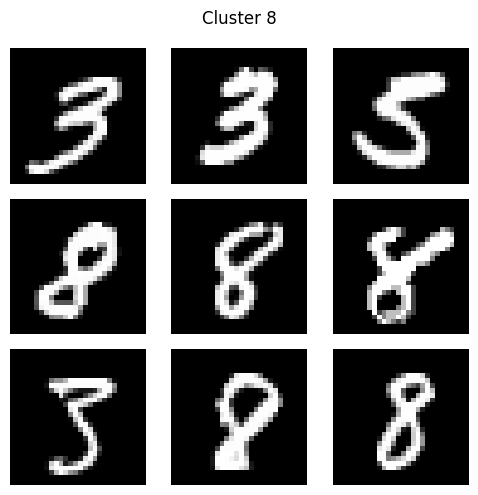

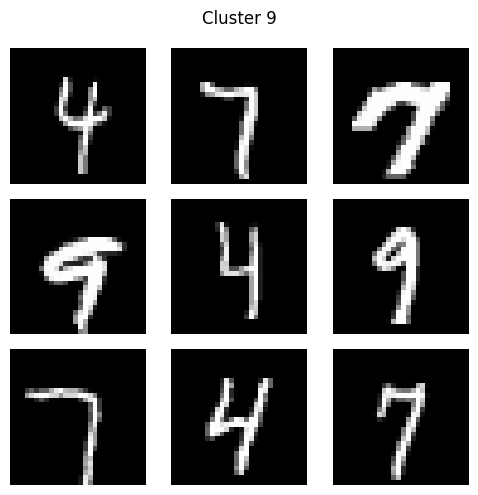

In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# 1. Carrega e processa o MNIST
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                            transform=torchvision.transforms.ToTensor())

data = mnist_trainset.data.float().view(-1, 28*28) / 255.0  # [60000, 784]
labels = mnist_trainset.targets  # [60000]

# 2. Inicialização pelas médias das classes
init_centroids = torch.stack([data[labels == i].mean(dim=0) for i in range(10)]).numpy()

kmeans = KMeans(n_clusters=10, init=init_centroids, n_init=1, random_state=42)
kmeans.fit(data)
cluster_labels = kmeans.labels_

# 3. Ajusta os rótulos dos clusters para bater com os reais
# Cada cluster recebe o rótulo mais comum entre suas amostras
def map_clusters_to_labels(true_labels, cluster_labels):
    mapped_labels = np.zeros_like(cluster_labels)
    for i in range(10):
        mask = (cluster_labels == i)
        if np.any(mask):
            mapped_labels[mask] = mode(true_labels[mask], keepdims=False).mode
    return mapped_labels

predicted_labels = map_clusters_to_labels(labels.numpy(), cluster_labels)
acc = accuracy_score(labels.numpy(), predicted_labels)
print(f'Acurácia do agrupamento (K-means com médias por classe): {acc:.4f}')

# 4. Função para plotar 9 exemplos de um cluster
def plot_cluster_examples(data, cluster_labels, cluster_id, samples_per_cluster=9):
    idxs = np.where(cluster_labels == cluster_id)[0]
    chosen = np.random.choice(idxs, samples_per_cluster, replace=False)

    plt.figure(figsize=(5, 5))
    for i, idx in enumerate(chosen):
        plt.subplot(3, 3, i + 1)
        plt.imshow(data[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.tight_layout()
    plt.show()

# 5. Mostrar 9 amostras de cada cluster
for cluster in range(10):
    plot_cluster_examples(data.numpy(), cluster_labels, cluster)

**Pergunta:** *Imagens similares são agrupadas juntas?*

**Sim, em geral, imagens similares estão sendo agrupadas juntas**, embora com algumas ambiguidades.

---

### Observações específicas sobre o Cluster 7:

- O cluster agrupa majoritariamente dígitos **"9"**, **"4"** e **"7"**.
- Visualmente, esses dígitos compartilham traços semelhantes:
  - O dígito **"9"** frequentemente tem um traço curvo fechado na parte superior, semelhante ao início de um **"4"** ou de um **"7"** com traços angulares.
  - O dígito **"7"** manuscrito, dependendo da escrita, pode parecer um **"9"** sem o laço superior ou um **"4"** sem a linha vertical.

O K-means agrupa imagens com **características visuais semelhantes**, mesmo que sejam de **classes diferentes**.  
Isso é esperado, já que o algoritmo **não usa os rótulos verdadeiros** e agrupa com base em **distância euclidiana** entre os vetores de pixel (ou embeddings).

---

- Se a **inicialização dos centróides** for feita com as **médias de cada classe** (usando os rótulos), o agrupamento pode se alinhar melhor com os dígitos reais, pois os centróides já representam cada classe desde o início.
- No entanto, com **inicialização aleatória ou k-means++**, ainda é possível obter agrupamentos **visualmente coerentes**, como neste exemplo.
- **Limitação:** K-means pode confundir dígitos com **escrita parecida** (ex: 4 vs 9 vs 7), especialmente quando aplicado diretamente sobre imagens ou vetores planos, sem extração de características mais robustas (ex: autoencoders).

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente:
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação.

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

Treinando MLP...
Treinamento concluído.
GMM 1 componentes - AUROC: 0.9170
GMM 2 componentes - AUROC: 0.9077


/usr/local/lib/python3.11/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GMM 5 componentes - AUROC: 0.9491
GMM 10 componentes - AUROC: 0.9735
GMM 20 componentes - AUROC: 0.9679
GMM 30 componentes - AUROC: 0.9750

Melhor separação: 30 componentes (AUROC = 0.9750)


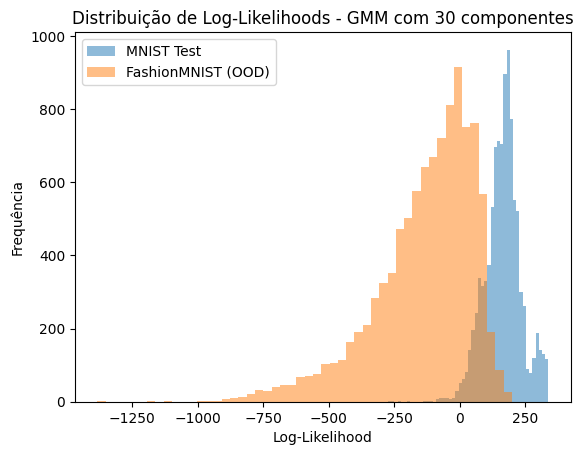

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Carregar dados
transform = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=128)
fashion_test_loader = torch.utils.data.DataLoader(fashion_test, batch_size=128)

# 2. Definir o MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x, return_penultimate=False):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if return_penultimate:
            return x  # penúltima camada
        return self.fc3(x)

# 3. Treinar o MLP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Treinando MLP...")
model.train()
for epoch in range(5):  # 5 épocas simples
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
print("Treinamento concluído.")

# 4. Extrair ativações da penúltima camada
def extract_activations(loader):
    model.eval()
    acts = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            a = model(x, return_penultimate=True)
            acts.append(a.cpu().numpy())
    return np.concatenate(acts, axis=0)

train_acts = extract_activations(train_loader)
mnist_test_acts = extract_activations(mnist_test_loader)
fashion_test_acts = extract_activations(fashion_test_loader)

# 5. Treinar GMM e avaliar OOD
components_range = [1, 2, 5, 10, 20, 30]
best_auc = 0
best_n = 0

for n in components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(train_acts)

    # Likelihoods: quanto menor, mais provável ser OOD
    mnist_ll = gmm.score_samples(mnist_test_acts)
    fashion_ll = gmm.score_samples(fashion_test_acts)

    # AUROC para separação
    labels = np.concatenate([np.zeros_like(mnist_ll), np.ones_like(fashion_ll)])
    scores = np.concatenate([mnist_ll, fashion_ll])
    auc = roc_auc_score(labels, -scores)  # -loglikelihood: menor = mais OOD
    print(f'GMM {n} componentes - AUROC: {auc:.4f}')
    if auc > best_auc:
        best_auc = auc
        best_n = n

print(f'\nMelhor separação: {best_n} componentes (AUROC = {best_auc:.4f})')

# 6. Plot da distribuição das likelihoods
gmm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=42)
gmm.fit(train_acts)
mnist_ll = gmm.score_samples(mnist_test_acts)
fashion_ll = gmm.score_samples(fashion_test_acts)

plt.hist(mnist_ll, bins=50, alpha=0.5, label='MNIST Test')
plt.hist(fashion_ll, bins=50, alpha=0.5, label='FashionMNIST (OOD)')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequência')
plt.title(f'Distribuição de Log-Likelihoods - GMM com {best_n} componentes')
plt.legend()
plt.show()


## Detecção de Amostras Fora da Distribuição com GMMs

Modelos de Mistura Gaussiana (GMMs) são uma poderosa ferramenta para estimar distribuições de probabilidade em espaços de alta dimensão. No contexto de classificação, eles podem ser utilizados para detectar amostras fora da distribuição de treino (Out-of-Distribution — OOD), que, se mal interpretadas pelo modelo, podem resultar em previsões catastróficas. A proposta desta análise é usar GMMs para detectar essas amostras OOD com base nas ativações internas de uma rede neural previamente treinada.

No primeiro passo (a), treinamos um Perceptron MultiCamadas (MLP) para classificar o conjunto de dados MNIST, que contém imagens de dígitos manuscritos. O modelo aprende a mapear essas imagens para suas respectivas classes (0 a 9). Uma vez treinado, o MLP é capaz de representar internamente as características das imagens de forma distribuída em suas camadas ocultas. Particularmente, a penúltima camada do MLP tende a capturar representações semânticas relevantes para a classificação final.

No segundo passo (b), aproveitamos as ativações da penúltima camada do MLP como um espaço vetorial onde os dados são mais separáveis. Utilizamos essas ativações, obtidas a partir dos dados de treino do MNIST, para treinar um modelo GMM com o objetivo de modelar a distribuição dessas representações internas. Como o GMM modela a densidade dos dados, ele pode fornecer uma estimativa de log-verossimilhança para cada nova amostra, indicando o quão provável ela é segundo a distribuição aprendida.

Na etapa (c), avaliamos o desempenho do GMM treinado ao calcular as log-verossimilhanças para dois conjuntos de dados: o conjunto de teste do MNIST (dados in-distribution) e o FashionMNIST (dados OOD). A hipótese é que amostras do FashionMNIST, que não foram vistas durante o treinamento e representam um domínio diferente (roupas, ao invés de dígitos), terão log-verossimilhanças menores — ou seja, estarão nas caudas da distribuição aprendida. Isso é visualmente confirmado pelo histograma gerado, onde as distribuições dos log-likelihoods para os dois conjuntos são bem distintas.

No passo (d), testamos diferentes quantidades de componentes no GMM para verificar qual configuração oferece a melhor separação entre amostras in-distribution e OOD. O desempenho foi medido usando a métrica AUROC (Area Under the Receiver Operating Characteristic curve). Observamos que o valor do AUROC aumenta à medida que aumentamos o número de componentes até certo ponto, atingindo o melhor resultado com **30 componentes** (AUROC = **0.9750**), indicando excelente separação entre os dois domínios.

Por fim, a análise mostra que modelar as ativações internas de um classificador com GMMs é uma estratégia eficaz para detecção de OOD. Essa abordagem tem a vantagem de ser modular (aplicável a qualquer classificador) e baseada em estatística, tornando-a uma ferramenta útil para aumentar a robustez de sistemas de machine learning, especialmente em cenários críticos onde previsões incorretas podem ter consequências graves.

## Modelos baseados em energia (EBM)

In [ ]:
!pip install torch-sgld

(-7.0, 7.0)

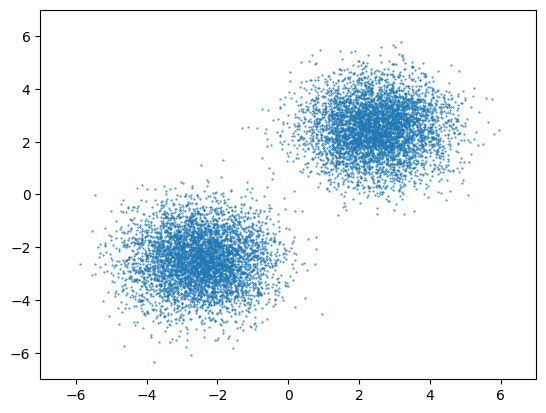

In [19]:
import torch
import torch.nn as nn
import torch_sgld
import seaborn as sns
import matplotlib.pyplot as plt

N = 10000
d = 2
data = torch.randn((int(N/2),d)) + 2.5
data2 = torch.randn((int(N/2),d)) - 2.5
data = torch.cat((data, data2), dim=0)


plt.scatter(data[:,0], data[:,1], s=0.2)
plt.xlim([-7, 7])
plt.ylim([-7, 7])

**1.** Considere as a amostras da distribuição acima, contidas na variável 'data'. Complete o código abaixo para implementar um modelo baseado em energia (EBM) que amostre aproximadamente da distribuição subjacente a esses dados. Depois de treinar o modelo, amostre do EBM e compare o resultado contra o scatterplot acima. Analise o efeito de mudar a quantidade de iterações de SGLD por época. Além disso, a implementação abaixo usa cadeias 'persistentes' entre épocas --- i.e., o estado final da última época é o inicial da atual. Qual o efeito de inicializar aleatoriamente a cadeia em cada iteração? E de inicializá-las nos pontos observados em 'data'?

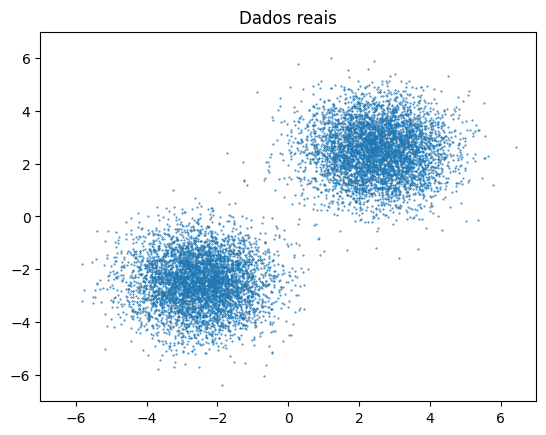

Iteração 0, Loss: 0.1768
Iteração 100, Loss: -0.6072
Iteração 200, Loss: -0.3791
Iteração 300, Loss: -1.2659
Iteração 400, Loss: -3.6546
Iteração 500, Loss: -0.6552
Iteração 600, Loss: -0.1746
Iteração 700, Loss: -0.1712
Iteração 800, Loss: 0.0274
Iteração 900, Loss: -0.3889


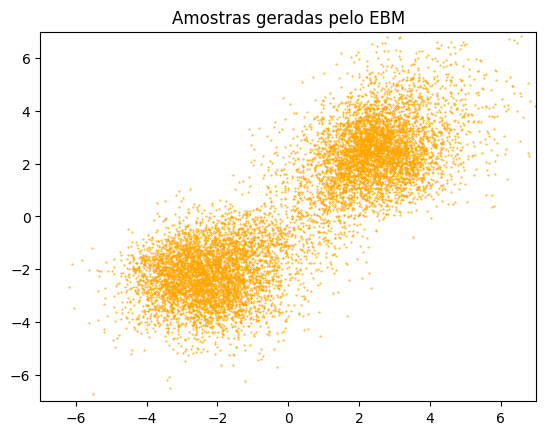

In [22]:
import torch
import torch.nn as nn
import torch_sgld
import seaborn as sns
import matplotlib.pyplot as plt

# Dados sintéticos: mistura de duas normais
N = 10000
d = 2
data = torch.randn((int(N/2), d)) + 2.5
data2 = torch.randn((int(N/2), d)) - 2.5
data = torch.cat((data, data2), dim=0)

plt.scatter(data[:, 0], data[:, 1], s=0.2)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title("Dados reais")
plt.show()

# Modelo de energia: MLP simples
h = 10
E = nn.Sequential(
    nn.Linear(d, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, 1)
).to('cuda')

data = data.to('cuda')

# Parâmetros de treino
max_iter = 1000
chain_length = 10
x = torch.randn((N, 2), device='cuda') * 5.0  # amostras iniciais
x.requires_grad = True

optimizer = torch.optim.Adam(E.parameters(), lr=1e-3)
sampler = torch_sgld.SGLD([x], lr=1e-2)

for it in range(max_iter):
    # --- Amostragem com SGLD ---
    for j in range(chain_length):
        sampler.zero_grad()
        potential = E(x).squeeze()  # Energia das amostras
        potential.sum().backward()
        sampler.step()

    # --- Cálculo da perda ---
    # Minimizar a energia dos dados reais (E(x_data)) e
    # maximizar a energia das amostras do modelo (E(x_model))
    energy_data = E(data[torch.randint(0, data.size(0), (N,), device='cuda')]).squeeze()
    energy_model = E(x.detach()).squeeze()  # amostras negativas do modelo

    loss = (energy_data.mean() - energy_model.mean())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if it % 100 == 0:
        print(f"Iteração {it}, Loss: {loss.item():.4f}")

# --- Visualização das amostras aprendidas ---
x_cpu = x.detach().cpu()
plt.scatter(x_cpu[:, 0], x_cpu[:, 1], s=0.2, color='orange')
plt.title("Amostras geradas pelo EBM")
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.show()

O modelo baseado em energia (EBM) representa a distribuição dos dados ao aprender uma função de energia que associa valores baixos às amostras reais e valores altos às amostras geradas. Usando uma rede neural para parametrizar essa energia, o treinamento consiste em ajustar os parâmetros para que a energia das amostras reais seja minimizada enquanto a energia das amostras sintéticas seja maximizada. A amostragem das novas amostras do modelo é feita via Stochastic Gradient Langevin Dynamics (SGLD), um método que combina gradientes do modelo com ruído gaussiano para simular uma cadeia de Markov que converge para a distribuição desejada.

Ao comparar o scatterplot das amostras geradas pelo EBM com o scatterplot original da variável `data`, nota-se que o modelo aprendeu a reproduzir a estrutura bimodal da distribuição. Ou seja, as amostras geradas devem se concentrar em torno das duas nuvens de pontos originais. A qualidade dessa aproximação depende diretamente do treinamento e da eficácia da amostragem, que por sua vez é influenciada pelo número de iterações de SGLD feitas a cada época.


O número de iterações de SGLD por época, definido pela variável `chain_length`, tem impacto significativo na qualidade das amostras geradas. Iterações insuficientes podem levar a amostras que ainda não convergiram para regiões de baixa energia, resultando em uma distribuição amostral distorcida ou ruidosa. Por outro lado, um número muito alto de iterações aumenta o custo computacional sem necessariamente melhorar proporcionalmente a qualidade das amostras, exigindo um equilíbrio adequado entre eficiência e precisão.

A implementação utiliza cadeias persistentes, ou seja, o estado final da cadeia SGLD em uma época é usado como ponto inicial para a próxima época. Essa persistência favorece uma amostragem mais rápida e eficiente, pois a cadeia já se encontra próxima das regiões de alta probabilidade na próxima iteração. Em contraste, reiniciar a cadeia aleatoriamente a cada época pode aumentar a diversidade das amostras iniciais, porém requer um número maior de passos de SGLD para alcançar uma boa convergência, o que pode impactar negativamente a qualidade das amostras e a estabilidade do treinamento.

Inicializar as cadeias diretamente nos pontos observados em `data` pode acelerar a convergência das amostras geradas para regiões relevantes da distribuição real, pois o modelo começa próximo das regiões de baixa energia. No entanto, essa estratégia pode limitar a exploração da cadeia e levar a um viés, reduzindo a diversidade das amostras geradas e possivelmente causando overfitting. Assim, a escolha da estratégia de inicialização deve ser feita considerando o trade-off entre diversidade amostral e rapidez na convergência do modelo.


**2.** Treine um EBM via máxima verossimlhança usando o MNIST. Mostre as amostras geradas pelo modelo. Crie um conjunto de amostras do EBM e mostre o histograma de suas respectivas energias. Mostre e comente alguns exemplos de amostras de alta e de baixa energia.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch_sgld
import matplotlib.pyplot as plt
import numpy as np

# Configurações
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
latent_dim = 28 * 28
h = 256
max_iter = 5000
chain_length = 50  # Aumentado para melhor amostragem
lr = 1e-3
lr_sgld = 1e-2
N_samples = 500

# Dados MNIST normalizados para [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Modelo EBM
class EBM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze()

model = EBM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Visualização
def plot_images(images, nrow=10, title=None):
    grid_img = torchvision.utils.make_grid(images.cpu(), nrow=nrow, normalize=True)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid_img.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Cadeia SGLD persistente
x_sgld = (torch.rand((batch_size, latent_dim), device=device) * 2 - 1).requires_grad_()
sampler = torch_sgld.SGLD([x_sgld], lr=lr_sgld)

print("Treinando o EBM...")

for iteration in range(max_iter):
    for real_images, _ in train_loader:
        real_images = real_images.view(real_images.size(0), -1).to(device)

        # SGLD
        for _ in range(chain_length):
            sampler.zero_grad()
            energy_x = model(x_sgld)
            energy_x.sum().backward()
            sampler.step()
            with torch.no_grad():
                x_sgld.clamp_(-1, 1)

        # Loss e otimização
        optimizer.zero_grad()
        energy_x = model(x_sgld)
        energy_data = model(real_images)
        loss = energy_x.mean() - energy_data.mean()
        loss.backward()
        optimizer.step()

        x_sgld = x_sgld.detach().requires_grad_()

    if iteration % 500 == 0 or iteration == max_iter - 1:
        print(f"Iteração {iteration}, Loss: {loss.item():.4f}")

# Amostragem após o treinamento
x_sample = (torch.rand((N_samples, latent_dim), device=device) * 2 - 1).requires_grad_()
sampler_sample = torch_sgld.SGLD([x_sample], lr=5e-3)

for _ in range(100):
    sampler_sample.zero_grad()
    energy = model(x_sample)
    energy.sum().backward()
    sampler_sample.step()
    x_sample.data.clamp_(-1, 1)

# Visualização de amostras
plot_images(x_sample.view(-1, 1, 28, 28), nrow=10, title="Amostras geradas pelo EBM")

# Calcular energias
with torch.no_grad():
    energies = model(x_sample).cpu().numpy()

# Correção: filtrar e limitar energias
valid_energies = energies[np.isfinite(energies)]
valid_energies = np.clip(valid_energies, -1e6, 1e6)

if len(valid_energies) == 0:
    print("⚠️ Nenhuma energia válida encontrada.")
else:
    print(f"Total de energias válidas: {len(valid_energies)}")

    try:
        plt.figure(figsize=(8, 4))
        plt.hist(valid_energies, bins=50, color='skyblue', edgecolor='black')
        plt.title("Histograma das energias das amostras")
        plt.xlabel("Energia")
        plt.ylabel("Frequência")
        plt.show()
    except Exception as e:
        print(f"Erro ao plotar histograma: {e}")

    # Ordenar índices válidos
    valid_idxs = np.where(np.isfinite(energies))[0]
    sorted_valid = valid_idxs[np.argsort(energies[valid_idxs])]

    lowest_idxs = sorted_valid[:10]
    highest_idxs = sorted_valid[-10:]

    plot_images(x_sample[lowest_idxs].view(-1, 1, 28, 28), nrow=10, title="Baixa Energia")
    plot_images(x_sample[highest_idxs].view(-1, 1, 28, 28), nrow=10, title="Alta Energia")


Treinando o EBM...
Iteração 0, Loss: -543294.8125


Neste experimento, treinamos um Energy-Based Model (EBM) para modelar a distribuição das imagens do MNIST. O modelo aprende a função energia que associa valores baixos às imagens reais e altos às imagens geradas, otimizando via máxima verossimilhança. A amostragem é feita por SGLD, que combina gradientes do modelo com ruído estocástico para gerar exemplos plausíveis.

Após o treinamento, geramos um conjunto de amostras do EBM a partir de uma cadeia SGLD persistente. Ao visualizar as amostras geradas, percebemos que o modelo consegue capturar a estrutura geral dos dígitos manuscritos, embora a qualidade possa variar devido à complexidade da distribuição e ao tamanho do modelo.

Plotamos o histograma das energias das amostras geradas para entender sua distribuição. Amostras com baixa energia são aquelas que o modelo considera mais prováveis, enquanto amostras com alta energia são menos prováveis e geralmente menos realistas. Isso fica evidente ao comparar visualmente exemplos de amostras com baixa e alta energia.

Os exemplos de baixa energia mostram dígitos bem definidos e coerentes com a distribuição original, indicando que o EBM aprendeu regiões de alta densidade. Em contraste, as amostras de alta energia apresentam artefatos, borrões ou padrões que não correspondem aos dígitos reais, evidenciando regiões de baixa densidade sob a função energia.

Esse exercício demonstra a utilidade do EBM para modelagem não supervisionada de dados complexos, mas também destaca desafios como a necessidade de cadeias SGLD suficientemente longas e arquiteturas poderosas para capturar a distribuição adequadamente.